In [52]:
from sympy import N, plot, symbols, Matrix, ones, pprint, Expr
from numpy import array
import numpy.typing as npt
from scipy.stats import norm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import kstest
import matplotlib.pyplot as plt

In [53]:
def lin_model(x: list|tuple, y: list|tuple) -> Expr:
    ''' Given two lists or tuples of x and y numbers in a linear relationship, return least-squares best fit as sympy expression.
        >>>lin_model([0, 1, 2, 3], [1, 3, 4, 4])
        x + 3/2
        >>>N(lin_model([2, 3, 5, 7, 9], [4, 5, 7, 10, 15]), 4) # from sympy import N
        1.518x + 0.3049
    '''
    # garbage filters
    assert x and isinstance(x, list|tuple), "input must be lists or tuples of ints or floats"
    assert y and isinstance(y, list|tuple), "input must be lists or tuples of ints or floats"
    bad_values_x, bad_values_y = {}, {}
    for index, value in enumerate(x):
        if not isinstance(value, (int,float)):
            bad_values_x[index] = (value, type(value).__name__)
    for index, value in enumerate(y):
        if not isinstance(value, (int,float)):
            bad_values_y[index] = (value, type(value).__name__)
    assert not (bad_values_x or bad_values_y), ("input must be lists or tuples of ints or floats:\n"
                                                "\t\teach item reads index: (bad value, bad value type)\n"
                                                     f"\t\tx-vector: {bad_values_x}\n"
                                                     f"\t\ty-vector: {bad_values_y}")
    # initialization
    from sympy import Matrix, symbols, ones
    onesV = ones(1, len(x)) # make vector of ones the same length as vector x
    y = Matrix(y)
    M = Matrix([onesV, x]).T

    # BEGIN: ensure that M.T @ M) is invertible
    assert (M.T @ M).det() != 0, ("det|(M.T @ M)| cannot be 0.\n"
                                        "This can happen with non-unique solutions:\n"
                                        "For example: lin_model([3, 3], [4, 5])")
    try:
        (M.T @ M).inv()
       
    except: # general catch-all
        # NonInvertibleMatrixError not recognized by Traceback
        print("ERROR")
        print("(M.T @ M) ="); pprint(M.T @ M); print(("(M.T @ M) is not invertible."
                                    "Suggestion: Make sure that you input at least 2 datapoints\n"
                                                 "\t    and that at least one of your datapoints is distinct."))
        return
    # END: ensure that M.T @ M) is invertible

    # the algorithm: linear algebra least-squares optimizer
    # vector a holds the coefficients of the equation y = a0 + a1 x
    a = (M.T @ M).inv() @ M.T @ y
    # initialize for returning a sympy expression
    x = symbols('x')
    return a[0] + x* a[1]

In [54]:
lin_model([3, 4], [4, 5])

x + 1

In [ ]:
def test_lin_model(X: iter, Y: iter) -> tuple:
    ''' Given two iterables of x and y numbers in a linear relationship,
        show graph of scatterplot and best-fit line,
        and return named tuple of expression of best-fit line and test results:
        (Best-Fit Line, Homogeneity of Variance, Independence of Errors, and Normally Distributed Errors)
        >>>lin_model([0, 1, 2, 3], [1, 3, 4, 4])
        [Image of scatterplot of recorded values and best-fit line]
        (x + 3/2, 0, 2, 0.74)
    '''
    # initialization
    from sympy import N, plot, symbols, Matrix, ones
    from numpy import array
    from statsmodels.stats.stattools import durbin_watson
    from scipy.stats import kstest
    from collections import namedtuple
    lm_results = \
    namedtuple('lm_results', 'expr HoV DW KS')
    
    # implementation
    expr = lin_model(X, Y)

    fig, ax = plt.subplots()
    ax.scatter(X, Y)
    plot(expr, fig=fig, ax=ax)
    
    x, y = symbols('x y')
    # y = recorded values, y_hat = predicted values
    # Y = Matrix(Y)
    y_hat = lin_model(X, Y).subs(x, Matrix(X))

    # sympy can't interpret scalar + vector
    # so make same-sized vector of 3/2s, then add the two vectors
    y_hat = y_hat.args[1] + y_hat.args[0] * ones(len(y_hat.args[1]), 1)

    residuals = list(y_hat - Matrix(Y))

    # Test 1: homogeneity of variance
    HoV = sum(residuals)
    # Test 2: Independence of Errors
    DW = durbin_watson(residuals)
    # Test 3: Normally distributed residuals
    # Kolmogorov-Smirnov Test
    # coerce residual vector values as np floats
    # extract p-value, round to two digits
    # no need for more because:
    # p-value < 0.05 means NOT normally distributed
    KS = round(float(kstest(array(residuals).astype(float), norm.cdf).pvalue), 2)

    # return expr, HoV, DW, KS
    expr = f"y = {expr}" # return a formatted string
    return lm_results(expr, HoV, DW, KS)

In [ ]:
test1 = test_lin_model([3, 9], [4, 12])

In [ ]:
test1

In [16]:
lin_model([3, 3], [4, 5])

NameError: name 'DMNonInvertibleMatrixError' is not defined

In [ ]:
x, y = symbols('x y')
# y = recorded values, y_hat = predicted values
y = Matrix([1, 3, 4, 4])
y_hat = lin_model([0, 1, 2, 3], [1, 3, 4, 4]).subs(x, Matrix([0, 1, 2, 3])); y_hat

In [ ]:
# sympy can't interpret scalar + vector
# so make same-sized vector of 3/2s, then add the two vectors
y_hat = y_hat.args[1] + y_hat.args[0] * ones(len(y_hat.args[1]), 1); y_hat

In [ ]:
residuals = list(y_hat - y); residuals

In [ ]:
# Test 1: Homogeneity of Variance
# residuals; do residuals sum to value close to zero?
sum(y_hat - y)

In [ ]:
# Test 2: Independence of Errors
durbin_watson(residuals)

In [ ]:
# Test 3: Normally distributed residuals
# Kolmogorov-Smirnov Test
# coerce residual vector values as np floats
# extract p-value, round to two digits
# p-value >0.05 means NOT normally distributed
round(float(kstest(array(residuals).astype(float), norm.cdf).pvalue), 2)

In [ ]:
from sympy import symbols, Matrix
a,b, c, d = symbols('a b c d')
M = Matrix([[a, b], [c, d]]).subs({a:2, b:4, c: 4, d:8})
B = M.inv()

In [ ]:
try:
    M.inv()
except:
    print("M ="); pprint(M); print(("M is not invertible. A matrix must be square AND invertible to invert.\n"
                                    "For example, det|M| cannot be 0. (There must be a unique solution.)\n"
                                    "Suggestion: Make sure that you input at least 2 datapoints\n"
                                    "\t    and that at least one of your datapoints is distinct."))
    exit

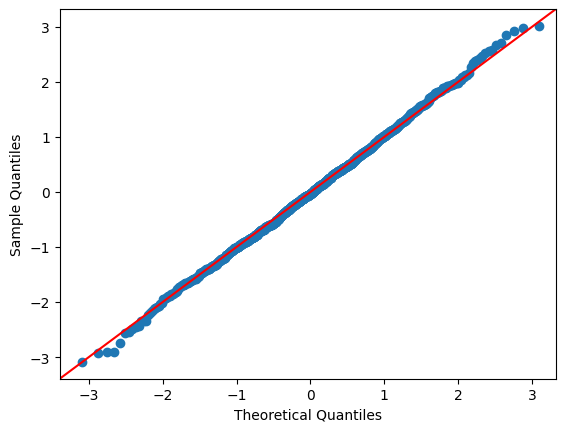

In [55]:
import numpy as np
import statsmodels.api as sm
import pylab

test = np.random.normal(0,1, 1000)

sm.qqplot(test, line='45')
pylab.show()